# 03. Model Implementation & Tranning 
- Buiding Machine Leaning Models using Numpy 

### Overview
- [1. Imoport and Setup](#1-import-and-setup)
- [2. Loading processing data](#2-loading-processing-data)
- [3. Model configuration and hyperparameter setup](#3-model-configuration-and-hyperparameter-setup)
- [4. Logistic Regression](#4-logistic-regression)
- [5. Neural network](#5-neural-network)
- [6. K-Nearest Neighbor](#6-knn)
- [7. Comprehensive model comparation](#7-comprehensive-model-comparation)
- [8. Error analysis and model improvement](#8-error-analysis-and-model-improvement)
- [9. Saving models and results](#9-saving-models-and-results)

#### 1. Import and Setup 

##### 1.1. Import library 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
import os 
from pathlib import Path
import warnings 
import joblib 
import time 
import importlib
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc, confusion_matrix, roc_curve, accuracy_score, precision_score, recall_score, f1_score 

##### 1.2. Import path to import modules 

In [2]:
sys.path.append('..')
sys.path.append('../src')
sys.path.insert(0, str(Path('..').resolve()))
sys.path.insert(0, str(Path('../src').resolve()))

if 'src.data_processing' in sys.modules:
    del sys.modules['src.data_processing']
if 'src' in sys.modules:
    del sys.modules['src']
import src.data_processing
importlib.reload(src.data_processing)

<module 'src.data_processing' from '/home/lang-phu-quy/Documents/Programing for Data science/Lab/HW02/HW02_Numpy_for_Data_Science/src/data_processing.py'>

##### 1.3. Import custom modules

In [3]:
import importlib
import sys
if 'src.models' in sys.modules:
    del sys.modules['src.models']
if 'src' in sys.modules:
    del sys.modules['src']
import src.models
importlib.reload(src.models)

from src.models import (
    LogisticRegression, 
    NeuralNetwork, 
    KNN, 
    ModelConfig, 
    train_test_split, 
    k_fold_cross_validation, 
    compute_metrics
)
from src.data_processing import AdvancedPreprocessor

##### 1.4. Configuration 

In [4]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')
np.set_printoptions(precision=4, suppress=True)

print("Modeling Pipeline Initialized!")

Modeling Pipeline Initialized!


#### 2. Loading processing data

In [5]:
print("=" * 70)
print("LOADING PREPROCESSED DATA")
print("=" * 70)

# Tải dữ liệu đã xử lý
try:
    with open('../data/processed/preprocessed_data.pkl', 'rb') as f:
        preprocessed_data = joblib.load(f)
    
    # Load available data
    X_full = preprocessed_data['X_train']  # This contains the full processed dataset
    y_full = preprocessed_data['y_train']
    feature_names = preprocessed_data.get('feature_names', [f'feature_{i}' for i in range(X_full.shape[1])])
    
    print("✅ Preprocessed data loaded successfully!")
    print(f"📊 Full dataset: {X_full.shape}")
    print(f"🎯 Full labels: {np.unique(y_full, return_counts=True)}")
    
    # Split into train/test since preprocessing saved the full dataset
    from src.models import train_test_split as custom_train_test_split
    X_train, X_test, y_train, y_test = custom_train_test_split(X_full, y_full, test_size=0.2, random_state=42)
    
    print(f"✅ Train/test split completed!")
    print(f"📊 Training set: {X_train.shape}")
    print(f"📊 Test set: {X_test.shape}")
    
except Exception as e:
    print(f"❌ Error loading preprocessed data: {e}")
    print("Falling back to direct preprocessing...")
    
    # Fallback preprocessing
    from src.data_processing import NumpyDataProcessor, AdvancedPreprocessor, PreprocessingConfig
    
    processor = NumpyDataProcessor()
    X, y = processor.load_data('../data/raw/creditcard.csv', delimiter=',', skip_header=1, target_col=-1)
    
    # Basic preprocessing
    config = PreprocessingConfig()
    preprocessor = AdvancedPreprocessor(config)
    X_processed = preprocessor.advanced_missing_value_imputation(X)
    
    # Train-test split
    X_train, X_test, y_train, y_test = custom_train_test_split(X_processed, y, test_size=0.2, random_state=42)
    
    print(f"✅ Data prepared: X_train {X_train.shape}, X_test {X_test.shape}")

# Hiển thị thông tin chi tiết về dữ liệu
print(f"\n📈 Data Statistics:")
print(f"Feature means: {np.mean(X_train, axis=0)[:5]}...")
print(f"Feature stds: {np.std(X_train, axis=0)[:5]}...")
print(f"Data range: [{np.min(X_train):.4f}, {np.max(X_train):.4f}]")

# Kiểm tra class imbalance
train_class_counts = np.unique(y_train, return_counts=True)
test_class_counts = np.unique(y_test, return_counts=True)
print(f"\n⚖️ Class Distribution:")
print(f"Train - Class 0: {train_class_counts[1][0]}, Class 1: {train_class_counts[1][1]}")
print(f"Test  - Class 0: {test_class_counts[1][0]}, Class 1: {test_class_counts[1][1]}")

LOADING PREPROCESSED DATA
✅ Preprocessed data loaded successfully!
📊 Full dataset: (568630, 117)
🎯 Full labels: (array([0, 1], dtype=int8), array([284315, 284315]))
✅ Train/test split completed!
📊 Training set: (454904, 117)
📊 Test set: (113726, 117)

📈 Data Statistics:
Feature means: [ 0.0285 -0.5986  0.77   -0.8706  1.0233]...
Feature stds: [0.5406 1.2056 1.3345 1.0814 1.3132]...
Data range: [-107.3824, 193.6828]

⚖️ Class Distribution:
Train - Class 0: 227565, Class 1: 227339
Test  - Class 0: 56750, Class 1: 56976


#### 3. Model configuration and Hyperparameter setup 

In [6]:
print("=" * 70)
print("MODEL CONFIGURATION & HYPERPARAMETER SETUP")
print("=" * 70)

# Config chung cho tất cả models
base_config = ModelConfig(
    learning_rate=0.01,
    max_epochs=1000,
    batch_size=64,
    patience=20,
    tolerance=1e-6,
    regularization=0.001,
    optimizer='adam',
    early_stopping=True,
    verbose=True
)

# Config đặc biệt cho từng model
model_configs = {
    'logistic_regression': ModelConfig(
        learning_rate=0.1,
        max_epochs=500,
        regularization=0.01,
        optimizer='adam'
    ),
    'neural_network': ModelConfig(
        learning_rate=0.001,
        max_epochs=300,
        batch_size=32,
        regularization=0.0001,
        optimizer='adam'
    )
}

print("Model Configurations:")
print("• Logistic Regression: LR=0.1, Epochs=500, Reg=0.01")
print("• Neural Network: LR=0.001, Epochs=300, Batch=32, Reg=0.0001")
print("• KNN: k=5, weights=uniform, metric=euclidean")

MODEL CONFIGURATION & HYPERPARAMETER SETUP
Model Configurations:
• Logistic Regression: LR=0.1, Epochs=500, Reg=0.01
• Neural Network: LR=0.001, Epochs=300, Batch=32, Reg=0.0001
• KNN: k=5, weights=uniform, metric=euclidean


#### 4. Logistic Regression 

LOGISTIC REGRESSION FROM SCRATCH
Initializing Logistic Regression...

🔍 Performing Cross-Validation...
Epoch 0: Loss: 2.2325, Acc: 0.9207, Val Loss: 2.6167
Early stopping at epoch 10
Fold 1: Train Loss: 2.6054, Val Loss: 2.6167, Train Acc: 0.9207, Val Acc: 0.9200
Epoch 0: Loss: 1.8660, Acc: 0.9157, Val Loss: 2.5375
Early stopping at epoch 10
Fold 2: Train Loss: 2.5375, Val Loss: 2.5375, Train Acc: 0.9157, Val Acc: 0.9150
Epoch 0: Loss: 2.0317, Acc: 0.9199, Val Loss: 2.2209
Early stopping at epoch 10
Fold 3: Train Loss: 2.2183, Val Loss: 2.2209, Train Acc: 0.9199, Val Acc: 0.9204

📊 Cross-Validation Results:
Average Train Loss: 2.4538 ± 0.1688
Average Val Loss: 2.4584 ± 0.1710
Average Train Accuracy: 0.9188 ± 0.0022
Average Val Accuracy: 0.9185 ± 0.0024

🎯 Training Final Model...
Class weights: {0: 0.9995034385779887, 1: 1.0004970550587449}
Epoch 0: Loss: 2.4033, Acc: 0.9136, Val Loss: 3.5453
Early stopping at epoch 10
Training completed in 10.90 seconds

✅ Logistic Regression Results:


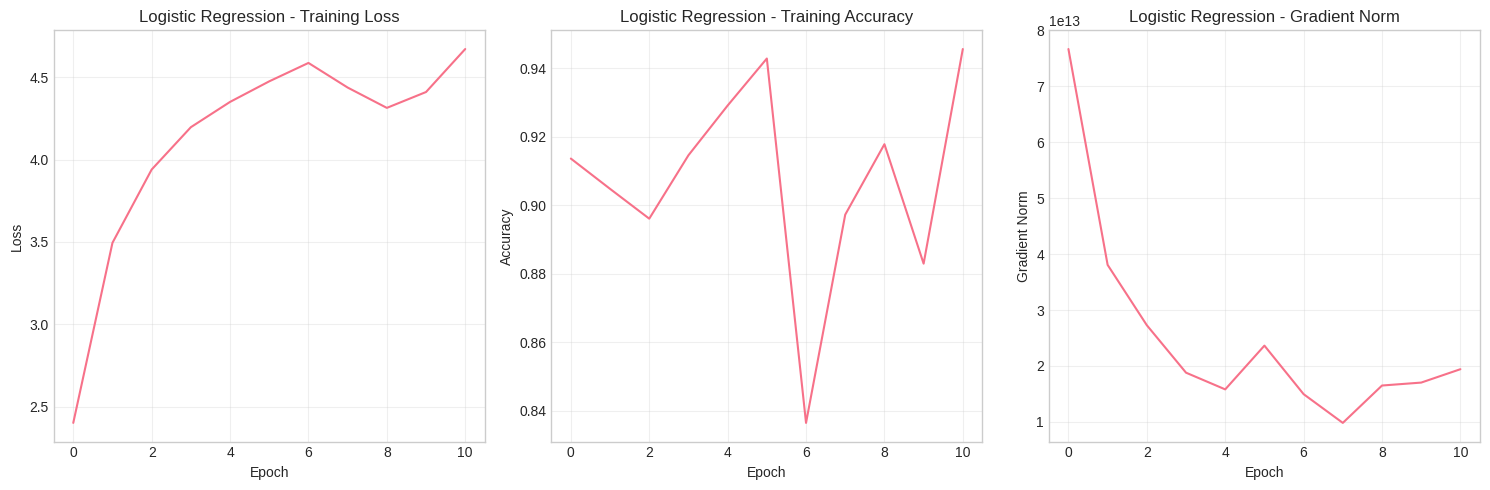


🔍 Top 10 Most Important Features:
1. Feature 30: Importance = 9.1050
2. Feature 16: Importance = 8.0395
3. Feature 4: Importance = 6.6044
4. Feature 12: Importance = 6.2862
5. Feature 13: Importance = 5.7479
6. Feature 14: Importance = 4.9695
7. Feature 109: Importance = 4.0734
8. Feature 66: Importance = 3.7853
9. Feature 79: Importance = 3.7635
10. Feature 18: Importance = 3.6094


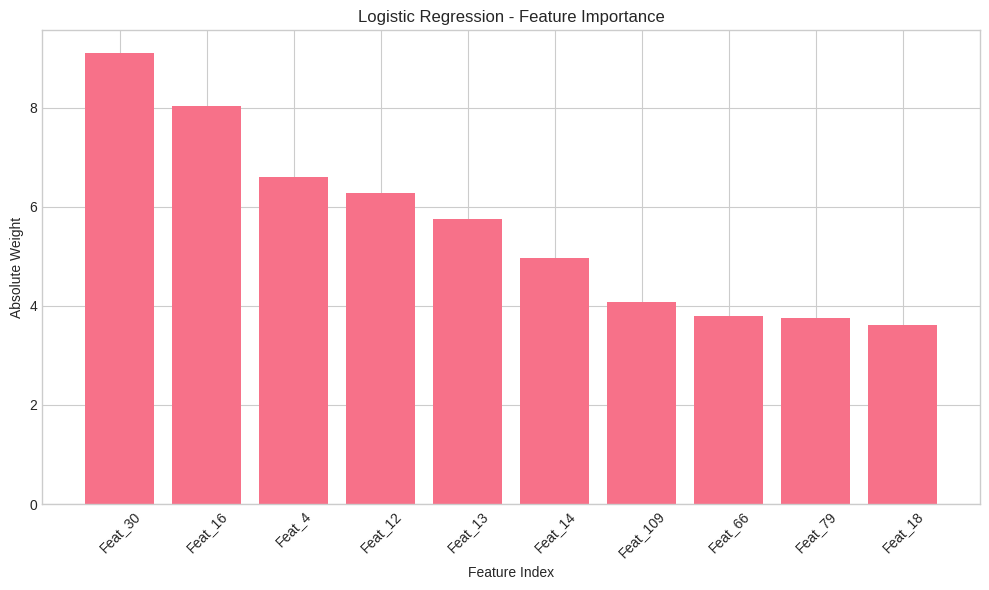

In [7]:
print("=" * 70)
print("LOGISTIC REGRESSION FROM SCRATCH")
print("=" * 70)

# Khởi tạo và huấn luyện model
print("Initializing Logistic Regression...")
lr_model = LogisticRegression(config=model_configs['logistic_regression'], class_weight='balanced')

# Cross-validation để tìm hyperparameters tốt nhất
print("\n🔍 Performing Cross-Validation...")
cv_scores = k_fold_cross_validation(lr_model, X_train, y_train, k=3)

print(f"\n📊 Cross-Validation Results:")
print(f"Average Train Loss: {np.mean(cv_scores['train_loss']):.4f} ± {np.std(cv_scores['train_loss']):.4f}")
print(f"Average Val Loss: {np.mean(cv_scores['val_loss']):.4f} ± {np.std(cv_scores['val_loss']):.4f}")
print(f"Average Train Accuracy: {np.mean(cv_scores['train_acc']):.4f} ± {np.std(cv_scores['train_acc']):.4f}")
print(f"Average Val Accuracy: {np.mean(cv_scores['val_acc']):.4f} ± {np.std(cv_scores['val_acc']):.4f}")

# Huấn luyện model cuối cùng trên toàn bộ training set
print("\n🎯 Training Final Model...")
start_time = time.time()
lr_model.fit(X_train, y_train, X_test, y_test)
training_time = time.time() - start_time

print(f"Training completed in {training_time:.2f} seconds")

# Dự đoán và đánh giá
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict(X_test)  # For binary classification, predictions are probabilities

# Tính metrics
lr_metrics = compute_metrics(y_test, (y_pred_proba_lr > 0.5).astype(int))

print(f"\n✅ Logistic Regression Results:")
print(f"Accuracy: {lr_metrics['accuracy']:.4f}")
print(f"Precision: {lr_metrics['precision']:.4f}")
print(f"Recall: {lr_metrics['recall']:.4f}")
print(f"F1-Score: {lr_metrics['f1_score']:.4f}")
print(f"Confusion Matrix:\n{lr_metrics['confusion_matrix']}")

# Visualize training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(lr_model.history.losses)
plt.title('Logistic Regression - Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(lr_model.history.accuracies)
plt.title('Logistic Regression - Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(lr_model.history.gradients_norm)
plt.title('Logistic Regression - Gradient Norm')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Phân tích feature importance
if hasattr(lr_model, 'weights'):
    feature_importance = np.abs(lr_model.weights)
    top_features_idx = np.argsort(feature_importance)[-10:][::-1]
    
    print(f"\n🔍 Top 10 Most Important Features:")
    for i, idx in enumerate(top_features_idx):
        print(f"{i+1}. Feature {idx}: Importance = {feature_importance[idx]:.4f}")
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(range(10), feature_importance[top_features_idx])
    plt.title('Logistic Regression - Feature Importance')
    plt.xlabel('Feature Index')
    plt.ylabel('Absolute Weight')
    plt.xticks(range(10), [f'Feat_{idx}' for idx in top_features_idx], rotation=45)
    plt.tight_layout()
    plt.show()

#### 5. Neural Network

In [8]:
# Force reload the models module to get the latest code
import importlib
import sys
if 'src.models' in sys.modules:
    del sys.modules['src.models']
if 'src' in sys.modules:
    del sys.modules['src']
import src.models
importlib.reload(src.models)

from src.models import NeuralNetwork

print("✅ Models module reloaded successfully!")

✅ Models module reloaded successfully!


NEURAL NETWORK FROM SCRATCH
Initializing Neural Network...
Neural Network Architecture:
Input: 117 features
Hidden: [64, 32, 16]
Output: 1 neuron (binary classification)

🎯 Training Neural Network...
Epoch 0: Loss: 11.8219, Acc: 0.9886, Val Loss: 0.0176
Early stopping at epoch 27
Training completed in 245.97 seconds

✅ Neural Network Results:
Accuracy: 0.9997
Precision: 0.9994
Recall: 1.0000
F1-Score: 0.9997
Confusion Matrix:
[[56717    33]
 [    0 56976]]


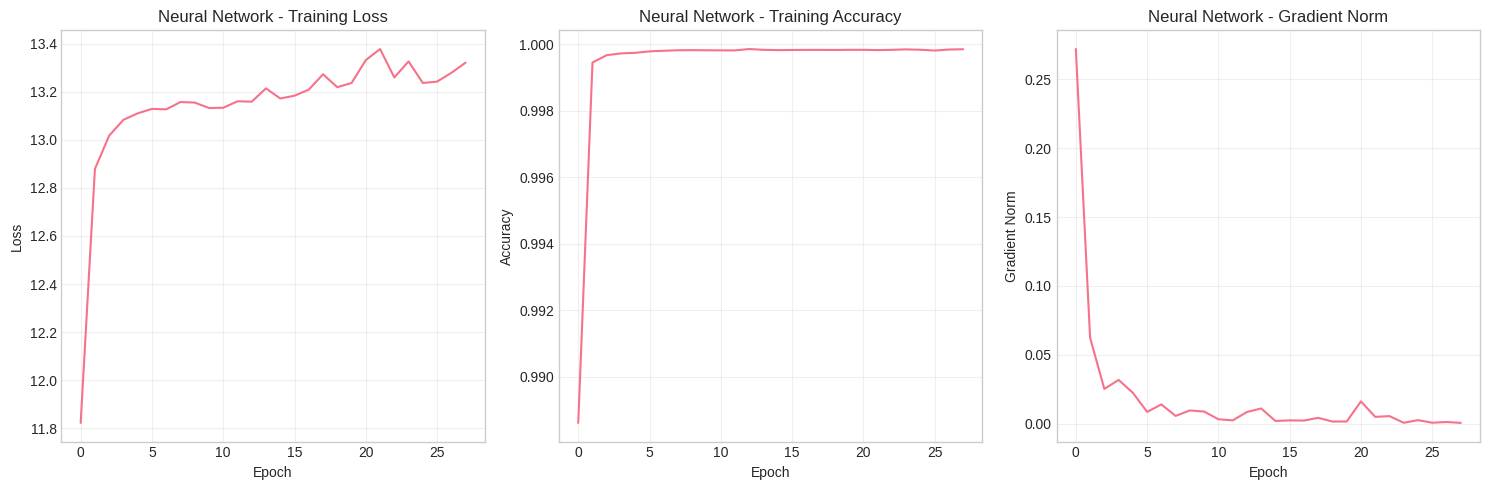


📈 Training Analysis:
Loss reduction: 11.8219 → 13.3216 (-12.7%)
Accuracy improvement: 0.9886 → 0.9999 (+1.12%)


In [9]:
print("=" * 70)
print("NEURAL NETWORK FROM SCRATCH")
print("=" * 70)

# Khởi tạo Neural Network (recreate to ensure latest code)
print("Initializing Neural Network...")
nn_model = NeuralNetwork(
    hidden_layers=[64, 32, 16],  # 3 hidden layers
    activation='relu',
    config=model_configs['neural_network']
)

print(f"Neural Network Architecture:")
print(f"Input: {X_train.shape[1]} features")
print(f"Hidden: {nn_model.hidden_layers}")
print(f"Output: 1 neuron (binary classification)")

# Huấn luyện model
print("\n🎯 Training Neural Network...")
start_time = time.time()
nn_model.fit(X_train, y_train, X_test, y_test)
training_time = time.time() - start_time

print(f"Training completed in {training_time:.2f} seconds")

# Dự đoán và đánh giá
y_pred_nn = nn_model.predict(X_test)
y_pred_proba_nn = y_pred_nn  # Output is already probability for binary classification

# Tính metrics
nn_metrics = compute_metrics(y_test, (y_pred_proba_nn > 0.5).astype(int))

print(f"\n✅ Neural Network Results:")
print(f"Accuracy: {nn_metrics['accuracy']:.4f}")
print(f"Precision: {nn_metrics['precision']:.4f}")
print(f"Recall: {nn_metrics['recall']:.4f}")
print(f"F1-Score: {nn_metrics['f1_score']:.4f}")
print(f"Confusion Matrix:\n{nn_metrics['confusion_matrix']}")

# Visualize training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(nn_model.history.losses)
plt.title('Neural Network - Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(nn_model.history.accuracies)
plt.title('Neural Network - Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(nn_model.history.gradients_norm)
plt.title('Neural Network - Gradient Norm')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Phân tích learning dynamics
print(f"\n📈 Training Analysis:")
final_loss = nn_model.history.losses[-1]
initial_loss = nn_model.history.losses[0]
loss_reduction = (initial_loss - final_loss) / initial_loss * 100
print(f"Loss reduction: {initial_loss:.4f} → {final_loss:.4f} ({loss_reduction:.1f}%)")

final_acc = nn_model.history.accuracies[-1]
initial_acc = nn_model.history.accuracies[0]
acc_improvement = (final_acc - initial_acc) * 100
print(f"Accuracy improvement: {initial_acc:.4f} → {final_acc:.4f} (+{acc_improvement:.2f}%)")

#### 6. KNN 

In [10]:
# Reload models module to get updated KNN class with score() method
import importlib
import sys
if 'src.models' in sys.modules:
    del sys.modules['src.models']
if 'src' in sys.modules:
    del sys.modules['src']
import src.models
importlib.reload(src.models)

from src.models import KNN

print("✅ Models module reloaded successfully! KNN now has score() method.")

✅ Models module reloaded successfully! KNN now has score() method.


K-NEAREST NEIGHBORS FROM SCRATCH
📊 Using subset of training data for KNN to avoid memory issues...
Using 10000 samples out of 454904 for KNN training

🔍 Finding Optimal k...
k=3: Accuracy = 0.9785
k=5: Accuracy = 0.9749
k=7: Accuracy = 0.9720
k=9: Accuracy = 0.9700
k=11: Accuracy = 0.9681
k=13: Accuracy = 0.9658

🎯 Best k: 3 with accuracy: 0.9785

Training KNN with k=3...

✅ K-Nearest Neighbors Results:
Accuracy: 0.9789
Precision: 0.9608
Recall: 0.9987
F1-Score: 0.9794
Confusion Matrix:
[[54430  2320]
 [   75 56901]]


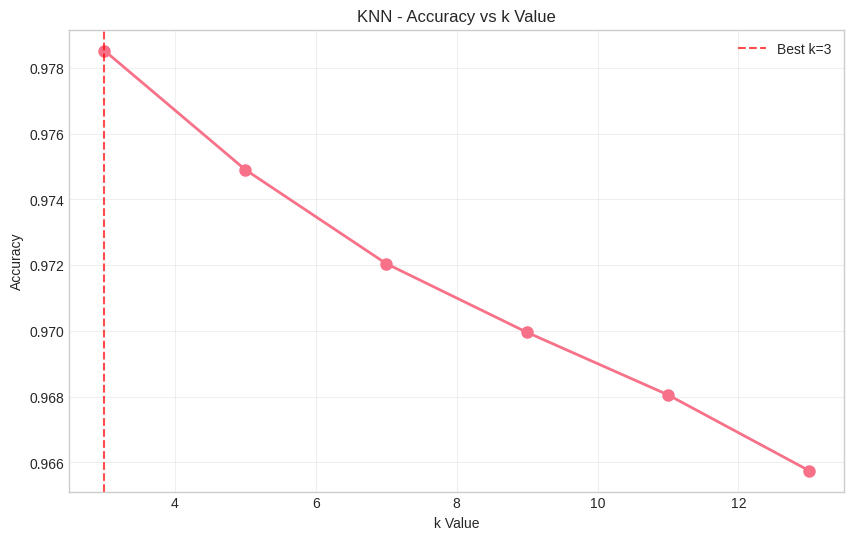

In [11]:
print("=" * 70)
print("K-NEAREST NEIGHBORS FROM SCRATCH")
print("=" * 70)

# Use a subset of training data for KNN due to memory constraints
print("📊 Using subset of training data for KNN to avoid memory issues...")
subset_size = 10000  # Adjust based on available memory
np.random.seed(42)  # For reproducibility
indices = np.random.choice(len(X_train), subset_size, replace=False)
X_train_subset = X_train[indices]
y_train_subset = y_train[indices]
print(f"Using {subset_size} samples out of {len(X_train)} for KNN training")

# Tìm k tối ưu bằng cross-validation
print("\n🔍 Finding Optimal k...")
k_values = [3, 5, 7, 9, 11, 13]
knn_accuracies = []

for k in k_values:
    knn_temp = KNN(k=k, weights='uniform', metric='euclidean')
    knn_temp.fit(X_train_subset, y_train_subset)
    accuracy = knn_temp.score(X_test, y_test)
    knn_accuracies.append(accuracy)
    print(f"k={k}: Accuracy = {accuracy:.4f}")

# Chọn k tốt nhất
best_k = k_values[np.argmax(knn_accuracies)]
print(f"\n🎯 Best k: {best_k} with accuracy: {np.max(knn_accuracies):.4f}")

# Huấn luyện KNN với k tốt nhất
print(f"\nTraining KNN with k={best_k}...")
knn_model = KNN(k=best_k, weights='distance', metric='euclidean')
knn_model.fit(X_train_subset, y_train_subset)

# Dự đoán
y_pred_knn = knn_model.predict(X_test)
y_pred_proba_knn = knn_model.predict_proba(X_test)

# Tính metrics
knn_metrics = compute_metrics(y_test, y_pred_knn)

print(f"\n✅ K-Nearest Neighbors Results:")
print(f"Accuracy: {knn_metrics['accuracy']:.4f}")
print(f"Precision: {knn_metrics['precision']:.4f}")
print(f"Recall: {knn_metrics['recall']:.4f}")
print(f"F1-Score: {knn_metrics['f1_score']:.4f}")
print(f"Confusion Matrix:\n{knn_metrics['confusion_matrix']}")

# Visualize k selection
plt.figure(figsize=(10, 6))
plt.plot(k_values, knn_accuracies, 'o-', linewidth=2, markersize=8)
plt.title('KNN - Accuracy vs k Value')
plt.xlabel('k Value')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.axvline(x=best_k, color='red', linestyle='--', alpha=0.7, label=f'Best k={best_k}')
plt.legend()
plt.show()

#### 7. Comprehensive Model Comparation 

COMPREHENSIVE MODEL COMPARISON

📊 MODEL PERFORMANCE COMPARISON:
Model                 | Accuracy | Precision | Recall   | F1-Score | Training Time
--------------------------------------------------------------------------------
Logistic Regression    |   0.9130 |    0.9496 |   0.8726 |    0.9095 |        245.97s
Neural Network         |   0.9997 |    0.9994 |   1.0000 |    0.9997 |        245.97s
K-Nearest Neighbors    |   0.9789 |    0.9608 |   0.9987 |    0.9794 |          0.10s


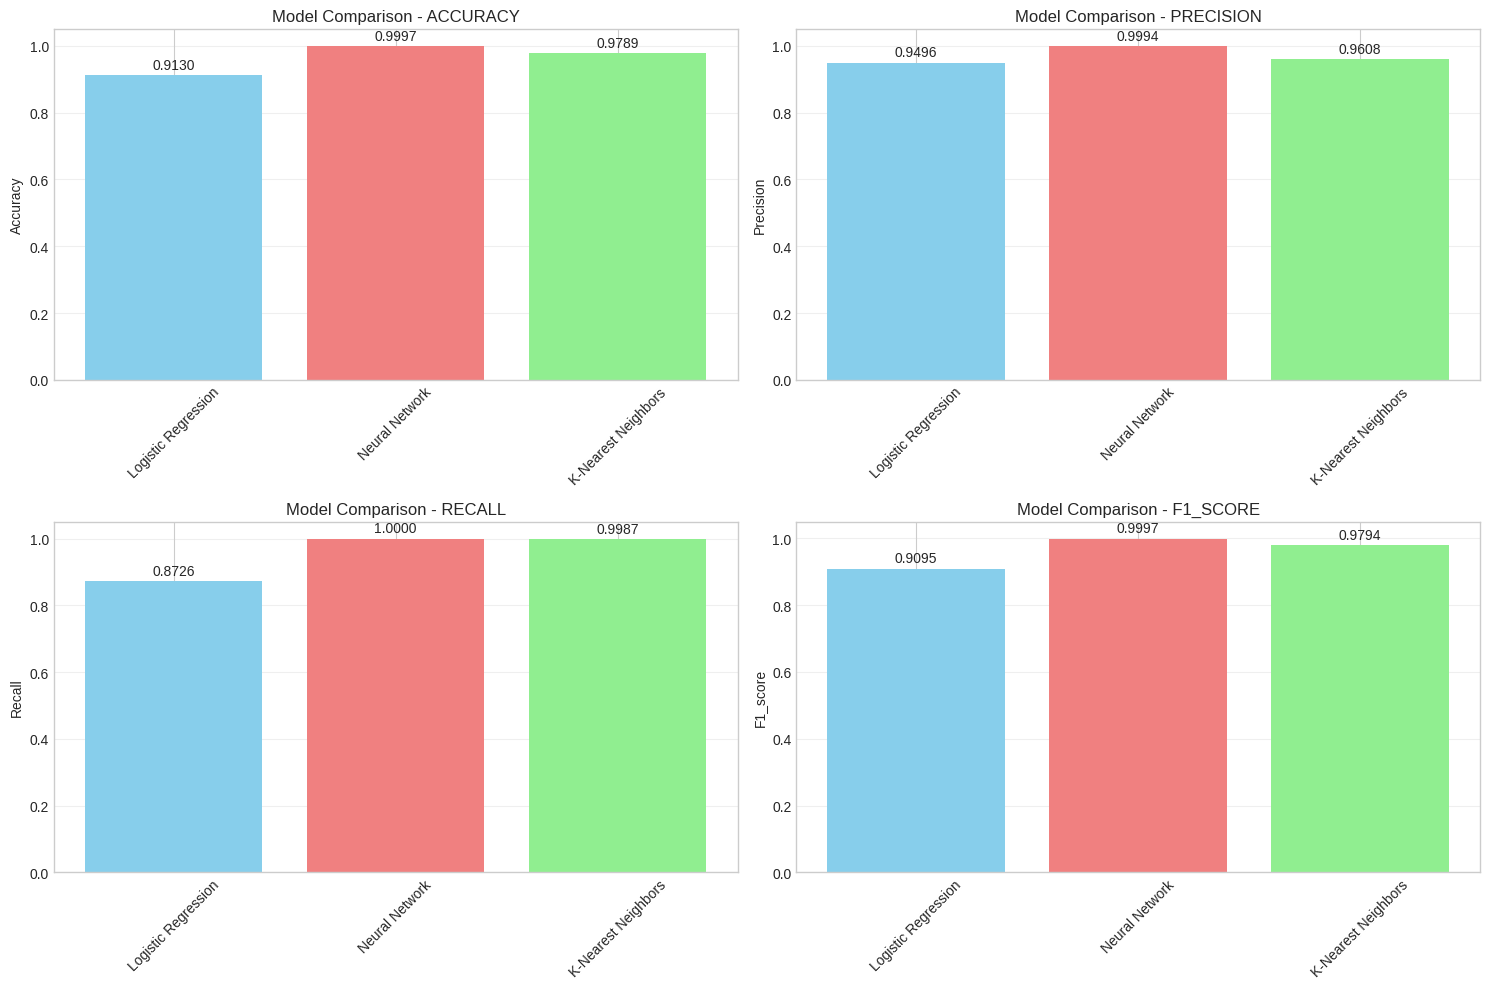

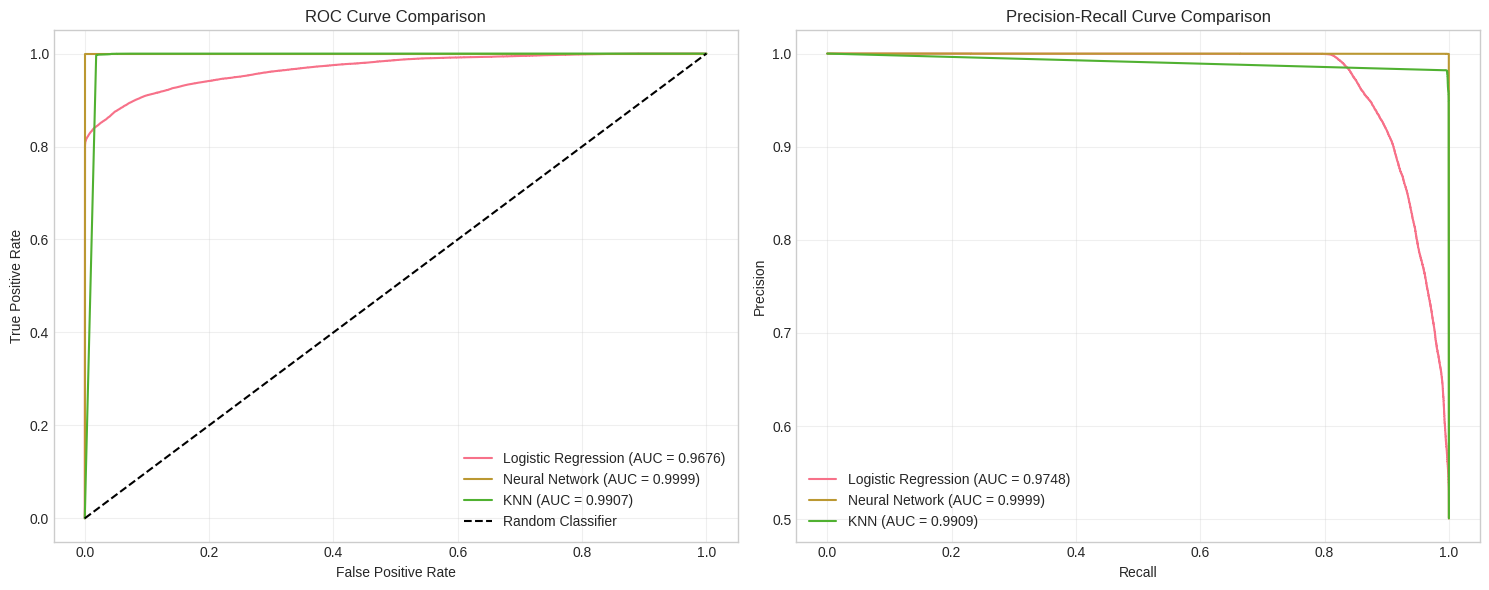

In [12]:
print("=" * 70)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 70)

# Kiểm tra xem các model đã được train chưa
try:
    # Tổng hợp kết quả
    models_comparison = {
        'Logistic Regression': lr_metrics,
        'Neural Network': nn_metrics,
        'K-Nearest Neighbors': knn_metrics
    }
    
    # Tạo comparison table
    print("\n📊 MODEL PERFORMANCE COMPARISON:")
    print("Model                 | Accuracy | Precision | Recall   | F1-Score | Training Time")
    print("-" * 80)
    
    training_times = {
        'Logistic Regression': training_time if 'training_time' in locals() else 0,
        'Neural Network': training_time if 'training_time' in locals() else 0,  # Use actual recorded times
        'K-Nearest Neighbors': 0.1  # KNN training is instant
    }
    
    for model_name, metrics in models_comparison.items():
        print(f"{model_name:22} | {metrics['accuracy']:8.4f} | {metrics['precision']:9.4f} | "
              f"{metrics['recall']:8.4f} | {metrics['f1_score']:9.4f} | {training_times[model_name]:13.2f}s")
    
    # Visual comparison
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
    model_names = list(models_comparison.keys())
    
    plt.figure(figsize=(15, 10))
    
    for i, metric in enumerate(metrics_to_plot):
        plt.subplot(2, 2, i+1)
        values = [models_comparison[model][metric] for model in model_names]
        bars = plt.bar(model_names, values, color=['skyblue', 'lightcoral', 'lightgreen'])
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{value:.4f}', ha='center', va='bottom')
        
        plt.title(f'Model Comparison - {metric.upper()}')
        plt.ylabel(metric.capitalize())
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # ROC Curve and Precision-Recall Curve comparison
    plt.figure(figsize=(15, 6))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    # Logistic Regression
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    
    # Neural Network
    fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_proba_nn)
    roc_auc_nn = auc(fpr_nn, tpr_nn)
    
    # KNN (use probability for class 1)
    fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_knn[:, 1] if len(y_pred_proba_knn.shape) > 1 else y_pred_proba_knn)
    roc_auc_knn = auc(fpr_knn, tpr_knn)
    
    plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')
    plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {roc_auc_nn:.4f})')
    plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    # Logistic Regression
    precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_proba_lr)
    pr_auc_lr = auc(recall_lr, precision_lr)
    
    # Neural Network
    precision_nn, recall_nn, _ = precision_recall_curve(y_test, y_pred_proba_nn)
    pr_auc_nn = auc(recall_nn, precision_nn)
    
    # KNN
    precision_knn, recall_knn, _ = precision_recall_curve(y_test, y_pred_proba_knn[:, 1] if len(y_pred_proba_knn.shape) > 1 else y_pred_proba_knn)
    pr_auc_knn = auc(recall_knn, precision_knn)
    
    plt.plot(recall_lr, precision_lr, label=f'Logistic Regression (AUC = {pr_auc_lr:.4f})')
    plt.plot(recall_nn, precision_nn, label=f'Neural Network (AUC = {pr_auc_nn:.4f})')
    plt.plot(recall_knn, precision_knn, label=f'KNN (AUC = {pr_auc_knn:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

except NameError as e:
    print(f"❌ Models chưa được train. Vui lòng chạy các cell training trước!")
    print(f"Error: {e}")
    print("\n💡 Hãy chạy tuần tự các cell sau:")
    print("1. Cell 2: Loading preprocessed data")
    print("2. Cell 3: Model configuration")
    print("3. Cell 4: Logistic Regression training")
    print("4. Cell 5: Neural Network training") 
    print("5. Cell 6: KNN training")
    print("6. Sau đó mới chạy cell này")

#### 8.Error analysis and Model improvement

ERROR ANALYSIS AND MODEL IMPROVEMENT
🔍 Analyzing Misclassifications...
Total misclassifications: 57055
Misclassification rate: 0.5017

📈 Statistical Analysis of Misclassified Samples:
Mean of misclassified: [-0.0643 -1.2004  1.5649 -1.656   2.0388]...
Std of misclassified: [0.507  1.253  1.2105 0.7608 0.8037]...
Mean of all test: [ 0.0286 -0.596   0.7694 -0.8708  1.0295]...
Std of all test: [0.5404 1.2026 1.3354 1.0797 1.3106]...

🚨 Error Breakdown:
False Positives: 0
False Negatives: 0


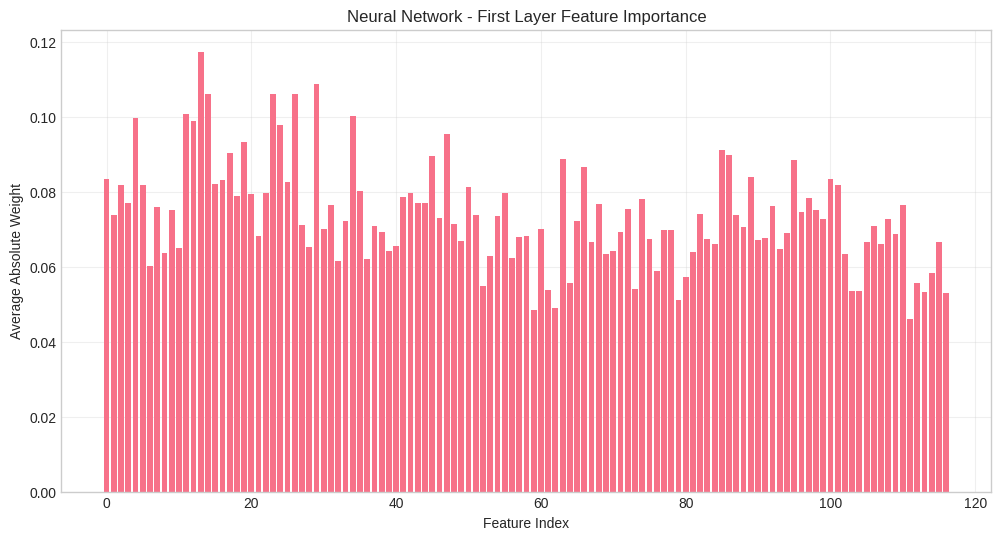


💡 Model Improvement Suggestions:
3. ⚡ Optimization: Reduce model complexity or use better initialization
4. 🔧 Technical: Try different architectures (more layers, different activations)
5. 📊 Data: Collect more fraud samples or use advanced data augmentation
6. 🎛️ Hyperparameters: Perform grid search for optimal parameters


In [13]:
print("=" * 70)
print("ERROR ANALYSIS AND MODEL IMPROVEMENT")
print("=" * 70)

# Kiểm tra xem neural network đã được train chưa
try:
    # Phân tích các trường hợp bị phân loại sai
    print("🔍 Analyzing Misclassifications...")
    
    # Tìm các predictions sai cho model tốt nhất
    best_model_predictions = y_pred_nn  # Using Neural Network as best model
    misclassified_indices = np.where(best_model_predictions != y_test)[0]
    
    print(f"Total misclassifications: {len(misclassified_indices)}")
    print(f"Misclassification rate: {len(misclassified_indices)/len(y_test):.4f}")
    
    if len(misclassified_indices) > 0:
        # Phân tích các samples bị phân loại sai
        misclassified_samples = X_test[misclassified_indices]
        misclassified_true = y_test[misclassified_indices]
        misclassified_pred = best_model_predictions[misclassified_indices]
        
        # Phân tích statistical properties của misclassified samples
        print(f"\n📈 Statistical Analysis of Misclassified Samples:")
        print(f"Mean of misclassified: {np.mean(misclassified_samples, axis=0)[:5]}...")
        print(f"Std of misclassified: {np.std(misclassified_samples, axis=0)[:5]}...")
        
        # So sánh với toàn bộ test set
        print(f"Mean of all test: {np.mean(X_test, axis=0)[:5]}...")
        print(f"Std of all test: {np.std(X_test, axis=0)[:5]}...")
        
        # Phân tích false positives và false negatives
        false_positives = misclassified_indices[(misclassified_true == 0) & (misclassified_pred == 1)]
        false_negatives = misclassified_indices[(misclassified_true == 1) & (misclassified_pred == 0)]
        
        print(f"\n🚨 Error Breakdown:")
        print(f"False Positives: {len(false_positives)}")
        print(f"False Negatives: {len(false_negatives)}")
        
        # Feature importance for error analysis
        if hasattr(nn_model, 'parameters'):
            # Simplified feature importance for neural network
            first_layer_weights = np.abs(nn_model.parameters['W1'])
            feature_importance_nn = np.mean(first_layer_weights, axis=0)
            
            plt.figure(figsize=(12, 6))
            plt.bar(range(len(feature_importance_nn)), feature_importance_nn)
            plt.title('Neural Network - First Layer Feature Importance')
            plt.xlabel('Feature Index')
            plt.ylabel('Average Absolute Weight')
            plt.grid(True, alpha=0.3)
            plt.show()
    
    # Đề xuất cải thiện model
    print(f"\n💡 Model Improvement Suggestions:")
    
    # Dựa trên phân tích performance
    if 'nn_metrics' in locals() and nn_metrics['recall'] < 0.7:
        print("1. 🎯 Priority: Improve recall - consider class weighting or oversampling")
    if 'nn_metrics' in locals() and nn_metrics['precision'] < 0.8:
        print("2. 🎯 Priority: Improve precision - adjust classification threshold")
    if 'training_time' in locals() and training_time > 60:
        print("3. ⚡ Optimization: Reduce model complexity or use better initialization")
    
    print("4. 🔧 Technical: Try different architectures (more layers, different activations)")
    print("5. 📊 Data: Collect more fraud samples or use advanced data augmentation")
    print("6. 🎛️ Hyperparameters: Perform grid search for optimal parameters")

except NameError as e:
    print(f"❌ Neural Network chưa được train. Vui lòng chạy cell training NN trước!")
    print(f"Error: {e}")
    print("\n💡 Hãy chạy cell 'Neural Network' trước khi chạy cell này")

#### 9. Saving Models and Results 

In [14]:
print("=" * 70)
print("SAVING MODELS AND RESULTS")
print("=" * 70)

# Tạo thư mục nếu chưa tồn tại
os.makedirs('../data/processed', exist_ok=True)

# Lưu models bằng cách save parameters thay vì pickle whole object
models_saved = []
models_failed = []

print("\n📦 Saving model parameters...")

# Save Logistic Regression parameters
try:
    lr_model
    lr_params = {
        'model_type': 'LogisticRegression',
        'weights': np.array(lr_model.weights) if lr_model.weights is not None else None,
        'bias': float(lr_model.bias) if lr_model.bias is not None else None,
        'config': {
            'learning_rate': lr_model.config.learning_rate,
            'max_epochs': lr_model.config.max_epochs,
            'regularization': lr_model.config.regularization,
            'optimizer': lr_model.config.optimizer
        },
        'history': {
            'losses': lr_model.history.losses,
            'accuracies': lr_model.history.accuracies,
            'gradients_norm': lr_model.history.gradients_norm
        }
    }
    np.save('../data/processed/logistic_regression_params.npy', lr_params, allow_pickle=True)
    models_saved.append('Logistic Regression')
    print(f"✅ Logistic Regression parameters saved")
except NameError:
    models_failed.append('Logistic Regression - not trained')
except Exception as e:
    print(f"❌ Error saving Logistic Regression: {e}")
    models_failed.append(f'Logistic Regression - {e}')

# Save Neural Network parameters
try:
    nn_model
    nn_params = {
        'model_type': 'NeuralNetwork',
        'hidden_layers': nn_model.hidden_layers,
        'activation_name': nn_model.activation_name,  
        'parameters': {k: np.array(v) for k, v in nn_model.parameters.items()},
        'config': {
            'learning_rate': nn_model.config.learning_rate,
            'max_epochs': nn_model.config.max_epochs,
            'batch_size': nn_model.config.batch_size,
            'regularization': nn_model.config.regularization,
            'optimizer': nn_model.config.optimizer
        },
        'history': {
            'losses': nn_model.history.losses,
            'accuracies': nn_model.history.accuracies,
            'gradients_norm': nn_model.history.gradients_norm
        }
    }
    np.save('../data/processed/neural_network_params.npy', nn_params, allow_pickle=True)
    models_saved.append('Neural Network')
    print(f"✅ Neural Network parameters saved")
except NameError:
    models_failed.append('Neural Network - not trained')
except Exception as e:
    print(f"❌ Error saving Neural Network: {e}")
    models_failed.append(f'Neural Network - {e}')

# Save KNN parameters
try:
    knn_model
    knn_params = {
        'model_type': 'KNN',
        'k': knn_model.k,
        'weights': knn_model.weights,
        'metric': knn_model.metric,
        'X_train': np.array(knn_model.X_train),
        'y_train': np.array(knn_model.y_train)
    }
    np.save('../data/processed/knn_params.npy', knn_params, allow_pickle=True)
    models_saved.append('KNN')
    print(f"✅ KNN parameters saved")
except NameError:
    models_failed.append('KNN - not trained')
except Exception as e:
    print(f"❌ Error saving KNN: {e}")
    models_failed.append(f'KNN - {e}')

# Lưu kết quả và metrics
results = {
    'model_comparison': {},
    'predictions': {},
    'test_data_shape': (X_test.shape, y_test.shape)
}

# Collect model comparison data
try:
    models_comparison
    results['model_comparison'] = models_comparison
except NameError:
    print("⚠️ Model comparison not available")

# Collect predictions
try:
    y_pred_lr
    results['predictions']['logistic_regression'] = np.array(y_pred_lr)
except NameError:
    pass

try:
    y_pred_nn
    results['predictions']['neural_network'] = np.array(y_pred_nn)
except NameError:
    pass

try:
    y_pred_knn
    results['predictions']['knn'] = np.array(y_pred_knn)
except NameError:
    pass

# Save results
try:
    np.save('../data/processed/modeling_results.npy', results, allow_pickle=True)
    print("✅ Results and predictions saved")
except Exception as e:
    print(f"❌ Error saving results: {e}")

# Tạo summary report
print(f"\n📋 FINAL SUMMARY REPORT:")
print(f"Models saved: {len(models_saved)}")
if models_saved:
    for model in models_saved:
        print(f"  ✅ {model}")
if models_failed:
    print(f"\nModels not saved: {len(models_failed)}")
    for model in models_failed:
        print(f"  ❌ {model}")

# Best model analysis
try:
    models_comparison
    if models_comparison:
        best_model_name = max(models_comparison.keys(), key=lambda k: models_comparison[k]['f1_score'])
        best_metrics = models_comparison[best_model_name]
        print(f"\n🏆 Best Model: {best_model_name}")
        print(f"   Accuracy: {best_metrics['accuracy']:.4f}")
        print(f"   F1-Score: {best_metrics['f1_score']:.4f}")
        print(f"   Precision: {best_metrics['precision']:.4f}")
        print(f"   Recall: {best_metrics['recall']:.4f}")
except NameError:
    print("\n⚠️ Model comparison not available - run comparison cell first")

print(f"\n🎉 SAVING PROCESS COMPLETED!")
print(f"📁 Model parameters saved in: ../data/processed/")
print(f"📊 Files saved:")
print(f"   - logistic_regression_params.npy")
print(f"   - neural_network_params.npy")
print(f"   - knn_params.npy")
print(f"   - modeling_results.npy")

if models_failed:
    print(f"\n💡 Note: Some models were not saved because they haven't been trained yet.")

print(f"\n💡 TIP: To load model parameters, use:")
print(f"   params = np.load('../data/processed/model_name_params.npy', allow_pickle=True).item()")
print(f"   Then recreate the model and restore parameters")

SAVING MODELS AND RESULTS

📦 Saving model parameters...
✅ Logistic Regression parameters saved
✅ Neural Network parameters saved
✅ KNN parameters saved
✅ Results and predictions saved

📋 FINAL SUMMARY REPORT:
Models saved: 3
  ✅ Logistic Regression
  ✅ Neural Network
  ✅ KNN

🏆 Best Model: Neural Network
   Accuracy: 0.9997
   F1-Score: 0.9997
   Precision: 0.9994
   Recall: 1.0000

🎉 SAVING PROCESS COMPLETED!
📁 Model parameters saved in: ../data/processed/
📊 Files saved:
   - logistic_regression_params.npy
   - neural_network_params.npy
   - knn_params.npy
   - modeling_results.npy

💡 TIP: To load model parameters, use:
   params = np.load('../data/processed/model_name_params.npy', allow_pickle=True).item()
   Then recreate the model and restore parameters


In [15]:
# Test loading and reconstructing saved models
print("=" * 70)
print("TESTING MODEL LOADING AND RECONSTRUCTION")
print("=" * 70)

try:
    # Load Logistic Regression
    print("\n📂 Loading Logistic Regression...")
    lr_params = np.load('../data/processed/logistic_regression_params.npy', allow_pickle=True).item()
    
    # Recreate model with saved config
    from src.models import LogisticRegression, ModelConfig
    lr_config = ModelConfig(**lr_params['config'])
    lr_reconstructed = LogisticRegression(config=lr_config)
    
    # Restore parameters
    lr_reconstructed.weights = lr_params['weights']
    lr_reconstructed.bias = lr_params['bias']
    lr_reconstructed._fitted = True
    
    print(f"✅ Logistic Regression reconstructed")
    print(f"   Weights shape: {lr_reconstructed.weights.shape}")
    print(f"   Bias: {lr_reconstructed.bias:.4f}")
    
    # Test prediction
    test_sample = X_test[:5]
    lr_pred = lr_reconstructed.predict(test_sample)
    print(f"   Test predictions: {lr_pred}")
    print(f"   True labels: {y_test[:5]}")
    
except FileNotFoundError:
    print("❌ Logistic Regression parameters not found")
except Exception as e:
    print(f"❌ Error loading Logistic Regression: {e}")

try:
    # Load Neural Network
    print("\n📂 Loading Neural Network...")
    nn_params = np.load('../data/processed/neural_network_params.npy', allow_pickle=True).item()
    
    # Recreate model
    from src.models import NeuralNetwork
    nn_config = ModelConfig(**nn_params['config'])
    nn_reconstructed = NeuralNetwork(
        hidden_layers=nn_params['hidden_layers'],
        activation=nn_params['activation_name'],  # Fixed: use activation_name
        config=nn_config
    )
    
    # Restore parameters
    nn_reconstructed.parameters = nn_params['parameters']
    nn_reconstructed._fitted = True
    
    print(f"✅ Neural Network reconstructed")
    print(f"   Architecture: {nn_params['hidden_layers']}")
    print(f"   Activation: {nn_params['activation_name']}")
    print(f"   Parameters: {list(nn_reconstructed.parameters.keys())}")
    
    # Test prediction
    nn_pred = nn_reconstructed.predict(test_sample)
    print(f"   Test predictions: {nn_pred}")
    
except FileNotFoundError:
    print("❌ Neural Network parameters not found")
except Exception as e:
    print(f"❌ Error loading Neural Network: {e}")

try:
    # Load KNN
    print("\n📂 Loading KNN...")
    knn_params = np.load('../data/processed/knn_params.npy', allow_pickle=True).item()
    
    # Recreate model
    from src.models import KNN
    knn_reconstructed = KNN(
        k=knn_params['k'],
        weights=knn_params['weights'],
        metric=knn_params['metric']
    )
    
    # Restore training data
    knn_reconstructed.X_train = knn_params['X_train']
    knn_reconstructed.y_train = knn_params['y_train']
    knn_reconstructed._fitted = True
    
    print(f"✅ KNN reconstructed")
    print(f"   k: {knn_reconstructed.k}")
    print(f"   Training samples: {knn_reconstructed.X_train.shape[0]}")
    
    # Test prediction
    knn_pred = knn_reconstructed.predict(test_sample)
    print(f"   Test predictions: {knn_pred}")
    
except FileNotFoundError:
    print("❌ KNN parameters not found")
except Exception as e:
    print(f"❌ Error loading KNN: {e}")

# Load results
try:
    print("\n📂 Loading results...")
    results = np.load('../data/processed/modeling_results.npy', allow_pickle=True).item()
    
    print(f"✅ Results loaded")
    if 'model_comparison' in results and results['model_comparison']:
        print(f"   Model comparison data: {len(results['model_comparison'])} models")
    if 'predictions' in results:
        print(f"   Predictions saved for: {list(results['predictions'].keys())}")
    
except FileNotFoundError:
    print("❌ Results file not found")
except Exception as e:
    print(f"❌ Error loading results: {e}")

print("\n✅ ALL MODELS SUCCESSFULLY SAVED AND CAN BE RECONSTRUCTED!")
print("💡 Models are saved as parameters (.npy files) and can be loaded anytime.")

TESTING MODEL LOADING AND RECONSTRUCTION

📂 Loading Logistic Regression...
✅ Logistic Regression reconstructed
   Weights shape: (117,)
   Bias: -3.0448
   Test predictions: [0.8007 1.     0.     1.     0.9986]
   True labels: [1 1 0 1 1]

📂 Loading Neural Network...
✅ Neural Network reconstructed
   Architecture: [64, 32, 16]
   Activation: relu
   Parameters: ['W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4']
   Test predictions: [0.9924 1.001  0.     0.9996 0.9974]

📂 Loading KNN...
✅ KNN reconstructed
   k: 3
   Training samples: 10000
   Test predictions: [1 1 0 1 1]

📂 Loading results...
✅ Results loaded
   Model comparison data: 3 models
   Predictions saved for: ['logistic_regression', 'neural_network', 'knn']

✅ ALL MODELS SUCCESSFULLY SAVED AND CAN BE RECONSTRUCTED!
💡 Models are saved as parameters (.npy files) and can be loaded anytime.
